# Python notebook to plot apical region response to stimulation.
Assumes folder directory structure:
<pre><code>  IMAGING
    image_stacks
    notebooks
    results
</code></pre>
To verify results incrementally, execute the code one block at a time using &lt;shift-return&gt;.

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage import exposure
from skimage.util import img_as_float32
from skimage.morphology import binary_erosion
from skimage.morphology import binary_dilation
from skimage.morphology import label
from skimage.morphology import remove_small_objects

#### User editable parameters.
NOTE: Uncomment one file name.

In [3]:
# editable user parameters
#filename = "../image_stacks/Mistgcamp-3.tif"        # 1Hz
#filename = "../image_stacks/Mistgcamp-3_0001.tif"   # 2Hz
filename = "../image_stacks/Mistgcamp-3_0002.tif"   # 5Hz
#filename = "../image_stacks/Mistgcamp-3_0003.tif"   # 10Hz
roi_quantile = 0.98
image_bits = 10


#### Get the image stack.


In [4]:
# get the image stack
A0 = io.imread(filename)
A0 = np.float32(A0/(2.0**image_bits))

# average out y-direction aliasing over every other line
for n in range(A0.shape[0] - 1): # moving average over every two lines
  A0[n] = (A0[n] + A0[n+1]) / 2.0


#### Unstimulated average over time.


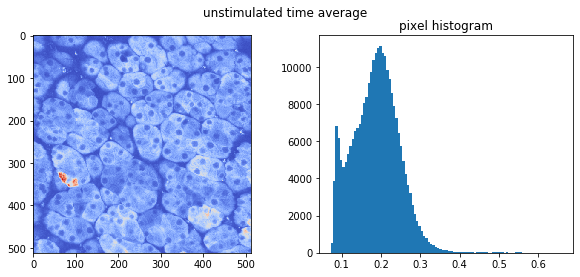

In [5]:
# unstimulated average over time
A = np.concatenate((A0[:100,:,:], A0[249:,:,:])) # unstimulated only
M = np.zeros(A[0].shape)
for n in range(A.shape[0]): # average over time
  M += A[n]
M /= A.shape[0]

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle('unstimulated time average')
ax[0].imshow(M, norm=None, cmap='coolwarm') # image
ax[1].hist(M.flatten(), bins=100) # histogram
plt.title("pixel histogram")
plt.show()


#### Stimulated average over time.


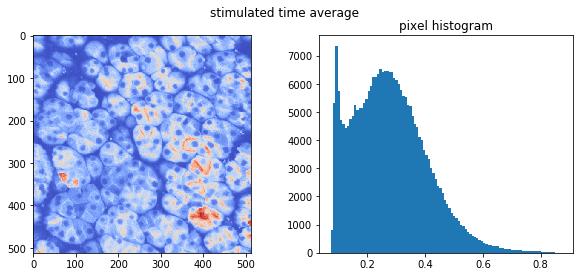

In [6]:
# stimulated average over time
A = A0[101:248,:,:] # stimulated only
N = np.zeros(A[0].shape)
for n in range(A.shape[0]): # average over time
  N += A[n]
N /= A.shape[0]

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle('stimulated time average')
ax[0].imshow(N, norm=None, cmap='coolwarm') # image
ax[1].hist(N.flatten(), bins=100) # histogram
plt.title("pixel histogram")
plt.show()


#### Stimulated minus unstimulated average over time.


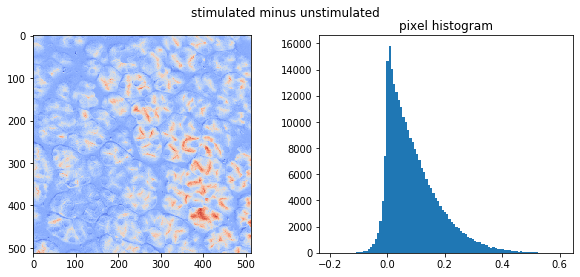

In [7]:
# difference: stimulated - unstimulated
O = N - M

# plot image
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle('stimulated minus unstimulated')
ax[0].imshow(O, norm=None, cmap='coolwarm') # image
ax[1].hist(O.flatten(), bins=100) # histogram
plt.title("pixel histogram")
plt.show()


#### Create apical region-of-interest mask.


number of apical regions identified:  19
apical ROI values:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
apical ROI pixel counts:  [140 137  72 291 189  66  65 303 142 267 216  54  61 111 888 247  87  58
  43]



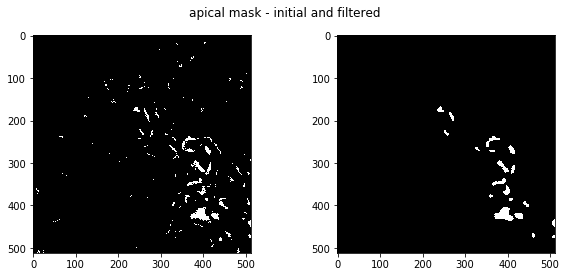

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = [10, 4])
fig.suptitle('apical mask - initial and filtered')

# difference threashold filter
P = (O > np.quantile(O,roi_quantile)).astype(float)

# plot image
ax[0].imshow(P, norm=None, cmap='gray');

# filtering: erosion, remove small, then dilation
Q = binary_erosion(P)
Q = remove_small_objects(Q, 16)
Q = binary_dilation(Q)
Q = binary_dilation(Q)
ax[1].imshow(Q, norm=None, cmap='gray') # plot image

# label and get pixel counts
Q, n = label(Q, return_num=True)
ROI, COUNT = np.unique(Q, return_counts=True)
print("number of apical regions identified: ", ROI.shape[0]-1)
print("apical ROI values: ", ROI[1:])
print("apical ROI pixel counts: ", COUNT[1:])
print()

# save the apical mask
if not os.path.exists("../results"):
  os.mkdir("../results")
io.imsave("../results/apical_mask.tif", np.int16(Q), check_contrast=False)


#### Plot apical region responses to stimulus.


*********************************************************************
 plots for ../image_stacks/Mistgcamp-3_0002.tif
*********************************************************************



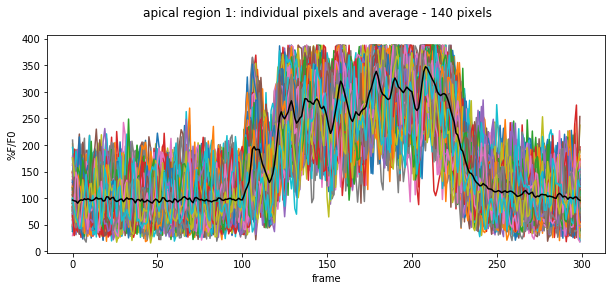

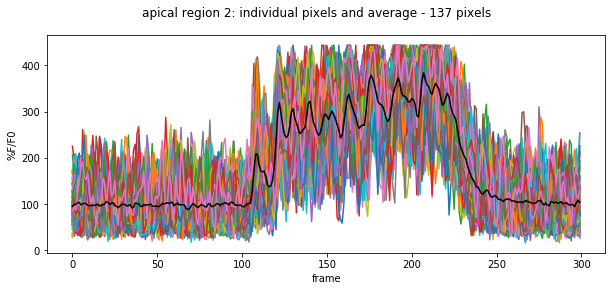

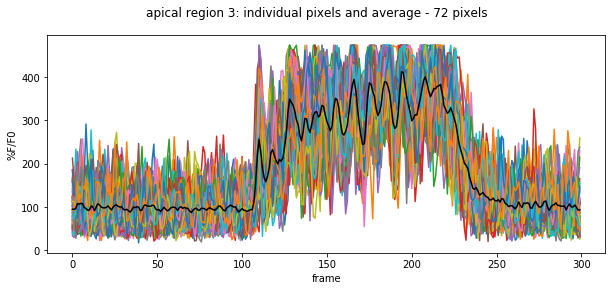

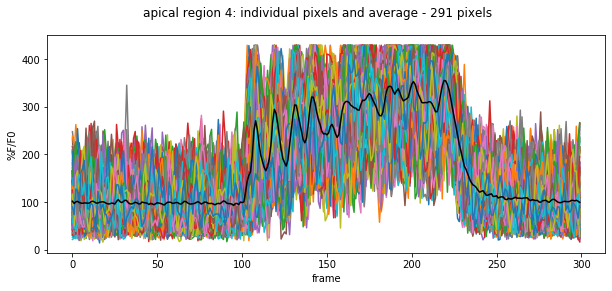

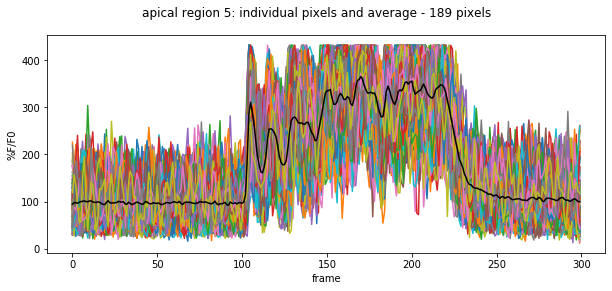

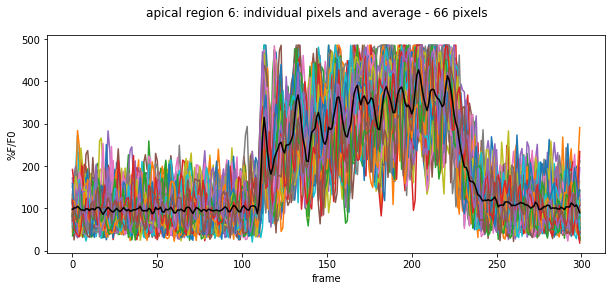

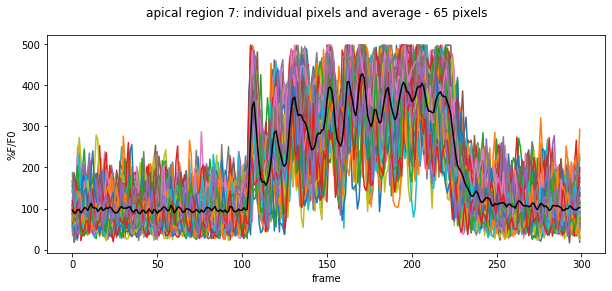

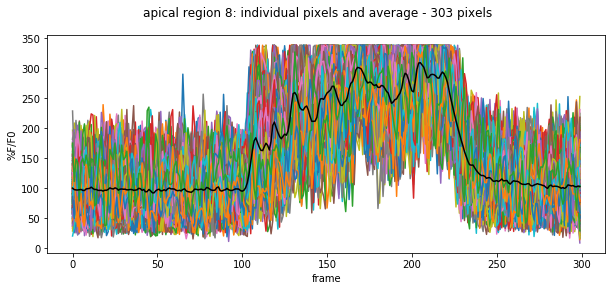

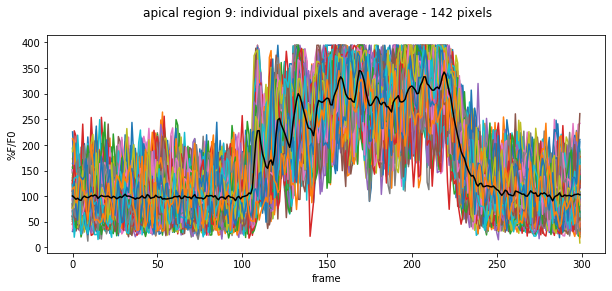

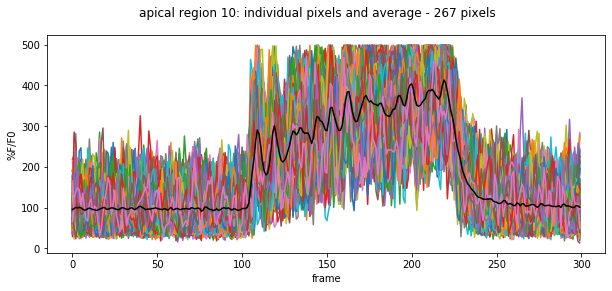

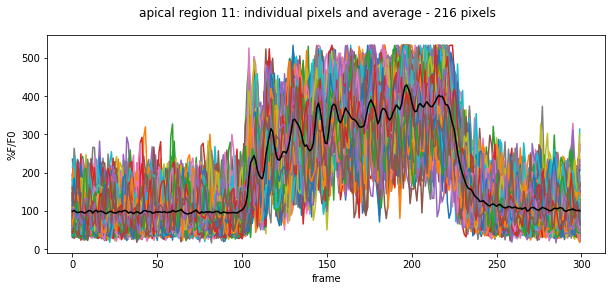

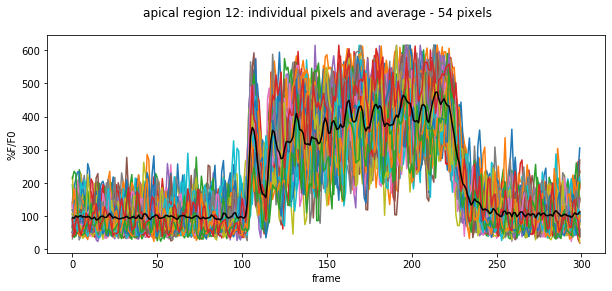

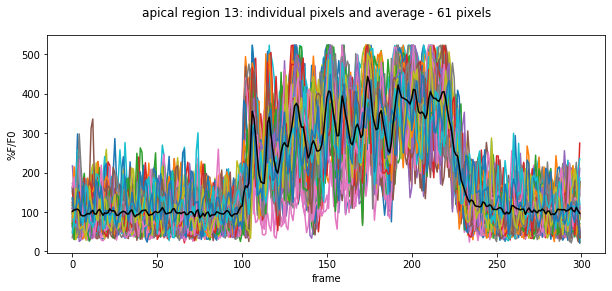

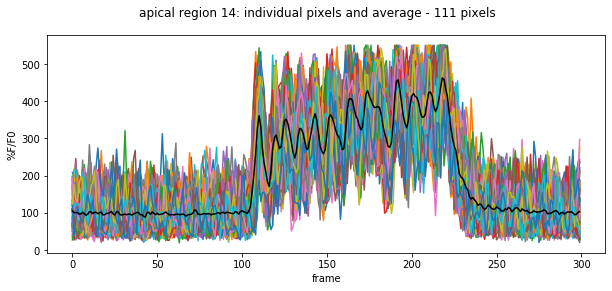

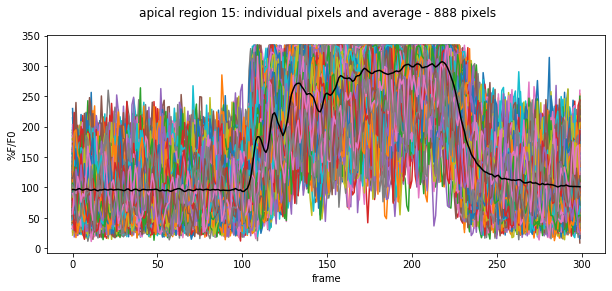

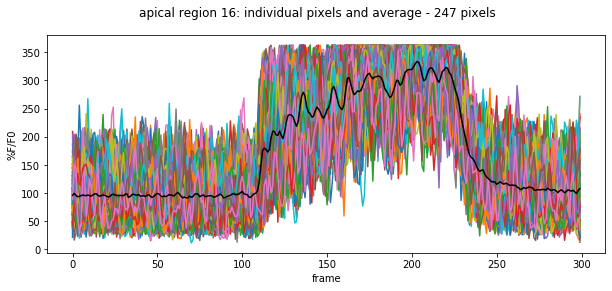

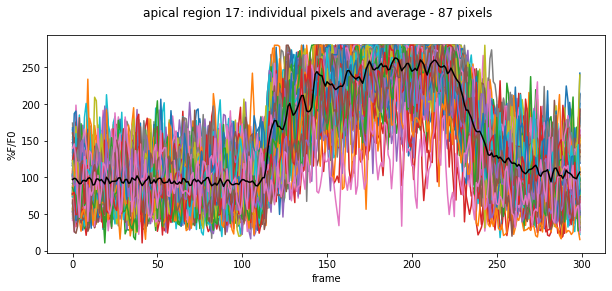

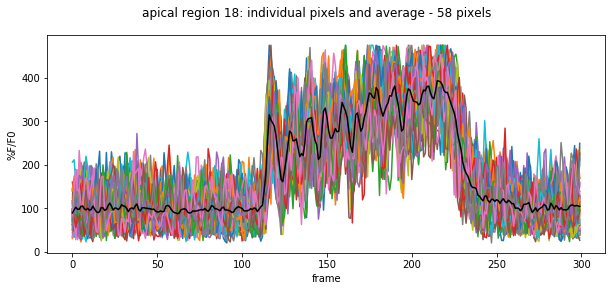

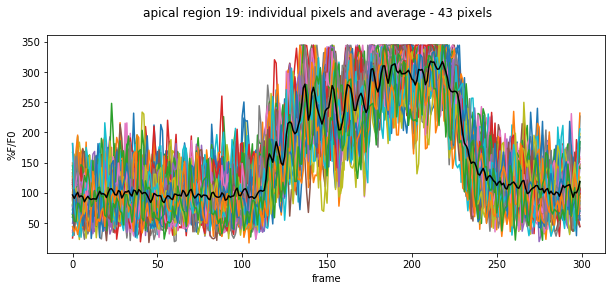

In [20]:
# apical region plots

print("*********************************************************************")
print(" plots for " + filename)
print("*********************************************************************")
print()
for c in ROI:
  if(c==0):
    continue
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize = [10, 4])
  fig.suptitle('apical region ' + str(c)+ ": individual pixels and average" + " - " +str(COUNT[c]) + " pixels")

  F0 = np.average(M[Q==ROI[c]]) # per region 
  #F0 = M[Q==ROI[c]] # per pixel
  S = 100 * A0[:, Q==ROI[c]] / F0
  T = np.sum(S, axis=1) / S.shape[1]
  ax.plot(S)
  ax.plot(T, color='black')
  ax.set(ylabel="%F/F0")
  ax.set(xlabel="frame")

  # save figure to pdf and average plot data to csv
  fig.savefig("../results/apical_region_" + str(c) + ".pdf")
  np.savetxt("../results/apical_region_" + str(c) + ".csv", T, delimiter=",", fmt="%.3e")

  plt.show()
  plt.close()
